In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
image_dir = "cavallo"

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)
    
    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


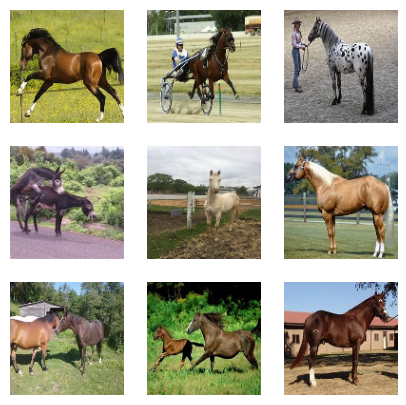

In [3]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [4]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)
    
    return parts
len(divide_image(images[1]))

9

In [5]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [6]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square
    
    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)
    
    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]
    
    return stitched_image

In [7]:
# import torch
# from torch_geometric.data import Data

# def create_graph(grid_size,image):
#     # Assume grid_size is a tuple (height, width)
#     h, w = grid_size
#     node_features = divide_image(image)
#     #node_features = divide_image(images[1])  # Example feature size for 40x40 RGB patches
#     edge_index = []

#     for i in range(h):
#         for j in range(w):
#             # Node index
#             idx = i * w + j
#             # Connect right
#             if j < w - 1:
#                 edge_index.append([idx, idx + 1])
#                 edge_index.append([idx + 1, idx])
#             # Connect down
#             if i < h - 1:
#                 edge_index.append([idx, idx + w])
#                 edge_index.append([idx + w, idx])
#             # Connect down-right (diagonal)
#             if i < h - 1 and j < w - 1:
#                 edge_index.append([idx, idx + w + 1])
#                 edge_index.append([idx + w + 1, idx])
#             # Connect down-left (diagonal)
#             if i < h - 1 and j > 0:
#                 edge_index.append([idx, idx + w - 1])
#                 edge_index.append([idx + w - 1, idx])

#     edge_index = torch.tensor(edge_index, dtype=torch.long).t()
#     graph = Data(x=node_features, edge_index=edge_index)
#     return graph

# num_patches = 9  # Total patches in a 3x3 grid
# grid_size = (3, 3)  # Assuming a square grid of patches
# graph = create_graph(grid_size)

# edge_index = graph.edge_index 
# node_features = graph.x
# #graph.x
import torch
from torch_geometric.data import Data
import numpy as np

def create_graph(grid_size, image):
    h, w = grid_size
    node_features = divide_image(image)  # Assuming this returns a list of image patches
    edge_index = []

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            # Connect right
            if j < w - 1:
                edge_index.append([idx, idx + 1])
                edge_index.append([idx + 1, idx])
            # Connect down
            if i < h - 1:
                edge_index.append([idx, idx + w])
                edge_index.append([idx + w, idx])
            # Connect down-right (diagonal)
            if i < h - 1 and j < w - 1:
                edge_index.append([idx, idx + w + 1])
                edge_index.append([idx + w + 1, idx])
            # Connect down-left (diagonal)
            if i < h - 1 and j > 0:
                edge_index.append([idx, idx + w - 1])
                edge_index.append([idx + w - 1, idx])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    node_features = torch.tensor(np.array(node_features), dtype=torch.float32)
    node_features = node_features.view(h * w, -1)  # Flatten each patch feature vector
    graph = Data(x=node_features, edge_index=edge_index)
    return graph


In [9]:
# import torch
# from torch_geometric.data import Data

# def input_graph(num_nodes, edge_index, node_features):
#     # Ensure node_features is a PyTorch tensor and flattened
#     node_features = torch.tensor(node_features, dtype=torch.float32)
#     node_features = node_features.view(num_nodes, -1)  # Flatten each patch feature vector
#     graph = Data(x=node_features, edge_index=edge_index)
#     return graph
# graph = input_graph(9, edge_index, node_features) 

input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)
    
    for idx, combination in enumerate(combinations):
        shuffled_image = stitch_shuffled_image(combination)
        graph = create_graph((3, 3), shuffled_image)  # Assuming 3x3 grid
        input_data.append(graph)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])


In [35]:
from torch.utils.data import Dataset, DataLoader
import torch

class GraphPuzzleDataset(Dataset):
    def __init__(self, graphs, targets):
        self.graphs = graphs
        self.targets = targets

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], torch.tensor(self.targets[idx], dtype=torch.float)

# Instantiate the dataset with your data
dataset = GraphPuzzleDataset(input_data, target_data)
# Instantiate the DataLoader
from torch_geometric.data import DataLoader as GeoDataLoader

# Note that we're using GeoDataLoader from torch_geometric.data, not torch.utils.data
data_loader = GeoDataLoader(dataset, batch_size=32, shuffle=True)




c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [36]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class PuzzleGNN(torch.nn.Module):
    def __init__(self, feature_size, num_classes):
        super(PuzzleGNN, self).__init__()
        self.conv1 = GCNConv(feature_size, 64)
        self.conv2 = GCNConv(64, 128)
        self.out = torch.nn.Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First Graph Convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Second Graph Convolution
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global Pooling
        x = global_mean_pool(x, batch)

        # Apply a final (linear) classifier.
        x = F.dropout(x, training=self.training)
        x = self.out(x)

        return F.log_softmax(x, dim=1)

# Determine feature size and number of classes from the dataset
feature_size = dataset[0][0].x.shape[1]
num_classes = dataset[0][1].shape[0]

# Instantiate the model
model = PuzzleGNN(feature_size, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(data_loader):
    model.train()
    total_loss = 0
    for data, target in data_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.argmax(dim=1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Run the training process
for epoch in range(10):  # adjust the number of epochs as needed
    loss = train(data_loader)
    print(f'Epoch {epoch+1}, Loss: {loss}')


Epoch 1, Loss: 14.937677271482421
Epoch 2, Loss: 2.2069792107837958
Epoch 3, Loss: 2.204829423020526
Epoch 4, Loss: 2.202714245203065
Epoch 5, Loss: 2.2014391070458945
Epoch 6, Loss: 2.200742305197367
Epoch 7, Loss: 2.201251177671479
Epoch 8, Loss: 2.2004569542117234
Epoch 9, Loss: 2.19980830797335
Epoch 10, Loss: 2.200319540791395


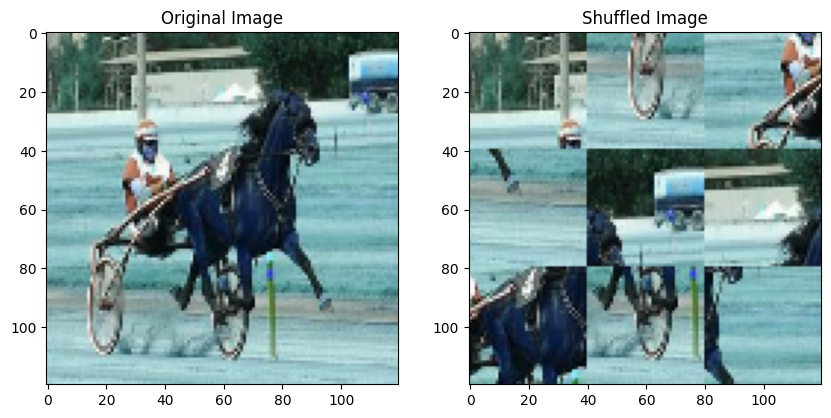

In [15]:
import matplotlib.pyplot as plt

# Example image loading and testing (replace with actual image loading)

# Test divide_image
parts = divide_image(images[1])
assert len(parts) == 9  # We expect 9 parts for a 3x3 grid

# Test generate_combinations and stitch_shuffled_image
combinations, positions = generate_combinations(parts, 1)
shuffled_image = stitch_shuffled_image(combinations[0])

# Display original and shuffled images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[1])
ax[0].set_title('Original Image')
ax[1].imshow(shuffled_image)
ax[1].set_title('Shuffled Image')
plt.show()
